<b>Deadline: D-30 </b>
<h1>Próximos passos:</h1>

<h3>- Calcular:</h3>

* Dados a serem extraídos da base de dados de Roma:

        - "O processo de segmentação é bom?" Para provar precisamos gerar os traces dos ônibus e comparar com os traces
        - Colocar uma linha nas CDFs
* Dados a serem extraídos da base de dados de Dublin:

        - Metrica Confinamento      
        - API Google
        - Avaliar aleatoriedade no encontro de veículos(definir raio)
        - Granuralidade(Quanto em quanto tempo há uma leitura no trace de Dublin/Roma)
        - Qual a área das cidades?
                * Roma: Centro: perímetro = 67.45Km área = 343.14Km² | Metrópole: perímetro = 185.38Km área = 2455.75Km²
                * Dublin: Centro: perímetro = 50.09Km área = 162.12Km² | Metrópole: perímetro = 116.48Km área = 609.42Km²
                Ferramenta: https://www.calcmaps.com/pt/map-area/
        - Fitting das distribuições https://moonbooks.org/Articles/How-to-plot-a-normal-distribution-with-matplotlib-in-python-/

In [38]:
import csv
import sys
import math
import platform
import os.path
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from datetime import timedelta

In [39]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import seaborn as sns

In [40]:
class Ponto:
    """A class that represents a certain point in the map at certain time"""
    def __init__(self,pointData):
        self.pointData = pointData

    def __str__(self):
        return self.pointData['Hora'] + " " + str(self.pointData['Coord'])

In [41]:
#  Lista de cores a serem utilizadas no mapa
listaCores = ['#d1432a', '#34f32a', '#ff3456']
#  dictionary com os pontos referentes a cada id
pontos = {}
#  dictionary com os intervalos de tempos entre os pontos para cada id
timeGaps = {}
#  dictionary os intervalos de distancias entre os pontos para cada id
coordGaps = {}
#  dict em que cada chave contem uma lista com os indices onde as separações devem ser feitas
separator = {}
#  lista com todos intervalos de tempo entre os pontos
allTimeGaps = []
timeGapsDiscrete = []
#  lista com todos intervalos de distancia entre os pontos
allCoordGaps = []
coordGapsDiscrete = []
#  listas dos pontos iniciais e finais de cada viagem
orig = []
dest = []

travels = []
keys = [] 

#  limites
# limitDist = 25
limitDist = 50
# limitDist = 350
# limitTempo = timedelta(seconds=15)
limitTempo = timedelta(seconds=18)
# limitTempo = timedelta(seconds=38)

In [42]:
if platform.system() == 'Linux':
    path = '/home/tulionpl/Repos/Pesquisa'
elif platform.system() == 'Windows':
    path = 'C:/Users/Tulio/Documents/Code/Pesquisa'
else:
    path = '/Users/tuliopolido/Documents/Pesquisa'

In [43]:
def convertHaversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r * 1000

In [44]:
def distDoisPontos(i, j, pontos):
    """Função para calcular a distância entre dois pontos"""

    dist = 0

    for k in range(i, j):
        point1 = pontos[k]
        point2 = pontos[k+1]

        pointCoord1 = point1.pointData['Coord']
        pointCoord2 = point2.pointData['Coord']

        dist += convertHaversine(pointCoord1[0],
                                 pointCoord1[1], pointCoord2[0], pointCoord2[1])

    return dist

In [45]:
def tempoDoisPontos(i, j, pontos):
    """Função para calcular o tempo entre dois pontos

    Argumentos:
    i -- Posição do primeiro ponto
    j -- Posição do segundo ponto
    pontos -- lista de pontos
    """

    ponto1 = pontos[i]
    ponto2 = pontos[j]
    pointTime = ponto1.pointData['Hora']
    pointTime = datetime.strptime(pointTime, '%Y-%m-%d %H:%M:%S')
    pointTime2 = ponto2.pointData['Hora']
    pointTime2 = datetime.strptime(pointTime2, '%Y-%m-%d %H:%M:%S')

    tempo = pointTime2-pointTime

    return tempo

In [9]:
def lerDublin():
    pontos = {}
    keys = []
    allTimeGaps = []
    allCoordGaps = []
    timeGapsDiscrete = []
    coordGapsDiscrete = []

    # Opening the CSV data and dropping columns that are not used
    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.drop(['line ID', 'direction', 'journey pattern ID', 'timeframe', 
                'operator', 'delay', 'block ID', 'stop ID'], axis = 1)
    
    # Sorting the dataframe and reindexing
    df_ordinated = df.sort_values(['vehicle ID','Timestamp'])
    df_ordinated.index = range(len(df_ordinated))
    # df_ordinated['Timestamp'] = pd.to_datetime(df_ordinated['Timestamp'],unit='us')

    # Each unique vehicle ID becomes a key 
    keys = df_ordinated['vehicle ID'].unique()
    keys = list(map(str, keys)).copy()
    keys = list(map(str.strip, keys)).copy()

    # Initializing points and
    for key in keys:
        pontos[key] = []

    # Creating the points
    for index, row in df_ordinated.iterrows():
        pnt = {}

        crds = (row[4],row[3])
        pnt['Coord'] = crds

        hrs = datetime.fromtimestamp(row[0]/1000000)
        hrs = hrs.strftime("%Y-%m-%d %H:%M:%S")
        pnt['Hora'] = hrs

        newInstance = Ponto(pnt)
        pontos[str(int(row[5]))].append(newInstance)

    # Calculate the time and coord gaps

    for key in keys:
        for i in range(0,len(pontos[key])-1): 
            hr = tempoDoisPontos(i,i+1,pontos[key])
            hr = hr.total_seconds()
            allTimeGaps.append(hr)
            dist = distDoisPontos(i,i+1,pontos[key])
            allCoordGaps.append(dist)

    timeGapsDiscrete = list(map(int, allTimeGaps)).copy()
    coordGapsDiscrete = list(map(int, allCoordGaps)).copy()

    return allTimeGaps, allCoordGaps, timeGapsDiscrete, coordGapsDiscrete, keys, pontos
    
allTimeGaps, allCoordGaps, timeGapsDiscrete, coordGapsDiscrete, keys, pontos = lerDublin()


In [46]:

def lerRoma():
    """Função para ler a base de dados com os valores ja calculados"""

    print('Lendo dados...')
    with open(path+'/data/timeGaps.txt', 'r') as file:
        allTimeGaps = list(map(float, file.readlines())).copy()

    with open(path+'/data/coordGaps.txt', 'r') as file:
        allCoordGaps = list(map(float, file.readlines())).copy()

    with open(path+'/data/keys.txt', 'r') as file:
        keys = list(map(str, file.readlines())).copy()
        keys = list(map(str.strip, keys)).copy()

    timeGapsDiscrete = list(map(int, allTimeGaps)).copy()
    coordGapsDiscrete = list(map(int, allCoordGaps)).copy()

    #  le arquivo com a lista de sequencia de ids
    with open(path+'/data/ids.txt', 'r') as file:
        ids = list(map(str, file.readlines())).copy()
        ids = list(map(str.strip, ids)).copy()

    #  le arquivo com a lista de sequencia de coordenadas
    with open(path+'/data/coordenadas.txt', 'r') as file:
        crds = list(map(str, file.readlines())).copy()
        crds = list(map(str.strip, crds)).copy()
        crds = list(map(eval, crds)).copy()

    #  le arquivo com a lista de sequencia de horas
    with open(path+'/data/hora.txt', 'r') as file:
        hrs = list(map(str, file.readlines())).copy()
        hrs = list(map(str.strip, hrs)).copy()

    #  inicializa o dict de pontos com uma lista para cada id
    for id in ids:
        pontos[id] = []

    for i in range(0, len(hrs)):
        pnt = {}
        pnt['Hora'] = hrs[i]
        pnt['Coord'] = crds[i]
        newInstance = Ponto(pnt)
        pontos[ids[i]].append(newInstance)

    print('Pronto!')

    return allTimeGaps, allCoordGaps, timeGapsDiscrete, coordGapsDiscrete, keys, pontos
allTimeGaps, allCoordGaps, timeGapsDiscrete, coordGapsDiscrete, keys, pontos = lerRoma()

Lendo dados...
Pronto!


In [ ]:
def granuralidade():
    fig, ax = plt.subplots()
    # axIns = ax.inset_axes([0.39, 0.39, 0.6, 0.6])

    # index = np.arange(0,56,5)
    # index = [int(i) for i in index]

    # ax.set_xticks(index)

    plt.hist(allTimeGaps, bins=range(0,31,5), edgecolor='black',align='mid',rwidth=1.5)
    # axIns.hist(allTimeGapsKmH, bins=range(0,251,25), edgecolor='black',align='mid')

    #plota linha com média
    plt.axvline(np.mean(allTimeGaps), color='red', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(np.mean(allTimeGaps)*2.1, max_ylim*0.5, 'Média: {:.1f}s'.format(np.mean(allTimeGaps)))

    # axIns.set_title("Em Km/H",x=0.7,y=0.8)
    plt.title('Granuralidade(Roma)')  
    plt.xlabel('Tamanho do intervalo em segundos')
    plt.ylabel('Quantidade de intervalos')
    plt.savefig(path+'/img/granuralidade_Roma.png', dpi=300, transparent=False, facecolor='white')

    plt.show()
    return np.mean(allTimeGaps)
    

In [ ]:
granuralidade()

In [46]:
def posTotal():
    posTotais = {}
    posTotais['lat'] = []
    posTotais['long'] = []
    tripArrays = []

    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.sort_values(['vehicle ID', 'Timestamp'])

    # Drop null journeys
    df = df.dropna()

    ids = df['vehicle ID'].unique()

    # Getting unique trips for each id
    for id in ids:
        df_id = df.loc[df['vehicle ID'] == id]
        tripArrays.append(df_id['vehicle journey ID'].unique())

    for array in tripArrays:
        for trip in array:
            dftrip = df.loc[df['vehicle journey ID'] == trip]
            
            for index,row in dftrip.iterrows():
                posTotais['lat'].append(row[9])
                posTotais['long'].append(row[8])

    return posTotais

posTotais = posTotal()

In [ ]:
def hist2d(posTotais):
    ### Plota um histograma 2d de todas posições de GPS
    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.sort_values(['vehicle ID', 'Timestamp'])

    # Drop null journeys
    df = df.dropna()

    ### Plota um histograma 2D dos destinos das trips
    x = []
    y = []

    for i in range(len(posTotais['long'])):
        if posTotais['long'][i] > -6.45 and posTotais['long'][i] < -6.12 and\
            posTotais['lat'][i] > 53.25 and posTotais['lat'][i] < 53.45:
            x.append(posTotais['long'][i])
            y.append(posTotais['lat'][i])

    x = np.array(x)
    y = np.array(y)

    print(x.min(), x.max(), y.min(), y.max())
    
    fig, ax = plt.subplots()

    # alpha=0.5 will make the plots semitransparent
    plt.hist2d(x, y,bins =(10,10), cmap=plt.cm.jet, alpha=0.6)

    ax.set_title('Histograma - Pontos de GPS(Dublin)')
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # you can also overlay your soccer field 
    plt.colorbar(label="Nº de pontos de destino")
    im = plt.imread(path+'/img/backmaps/backmap_all_Dublin.png')
    ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    # plt.savefig(path+"/img/hist2d_all_Dublin10x10.png", dpi=300, transparent=False, facecolor='white')
    
hist2d(posTotais)

In [68]:
def posOD():
    posOrigem = {}
    posDestino = {}
    posOrigem['lat'] = []
    posOrigem['long'] = []
    posDestino['lat'] = []
    posDestino['long'] = []
    tripArrays = []

    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.sort_values(['vehicle ID', 'Timestamp'])

    # Drop null journeys
    df = df.dropna()

    ids = df['vehicle ID'].unique()

    # Getting unique trips for each id
    for id in ids:
        df_id = df.loc[df['vehicle ID'] == id]
        tripArrays.append(df_id['vehicle journey ID'].unique())

    for array in tripArrays:
        for trip in array:
            dftrip = df.loc[df['vehicle journey ID'] == trip]
            if len(dftrip) > 5:
                inicio = dftrip.index[0]
                fim = dftrip.index[-1]

                z = datetime.fromtimestamp(dftrip['Timestamp'][inicio]/1000000)
                z = z.strftime("%Y-%m-%d %H:%M:%S")

                timeInicio = datetime.strptime(z,'%Y-%m-%d %H:%M:%S')
                horario1Inicio = datetime.strptime("2013-01-01 00:00:00",'%Y-%m-%d %H:%M:%S')
                horario1Fim = datetime.strptime("2013-01-01 05:59:59",'%Y-%m-%d %H:%M:%S')
                horario2Inicio = datetime.strptime("2013-01-01 06:00:00",'%Y-%m-%d %H:%M:%S')
                horario2Fim = datetime.strptime("2013-01-01 11:59:59",'%Y-%m-%d %H:%M:%S')
                horario3Inicio = datetime.strptime("2013-01-01 12:00:00",'%Y-%m-%d %H:%M:%S')
                horario3Fim = datetime.strptime("2013-01-01 17:59:59",'%Y-%m-%d %H:%M:%S')
                horario4Inicio = datetime.strptime("2013-01-01 18:00:00",'%Y-%m-%d %H:%M:%S')
                horario4Fim = datetime.strptime("2013-01-01 23:59:59",'%Y-%m-%d %H:%M:%S')

                # horarioInicio = horario1Inicio
                # horariofim = horario1Fim
                # horarioInicio = horario2Inicio
                # horariofim = horario2Fim
                # horarioInicio = horario3Inicio
                # horariofim = horario3Fim
                horarioInicio = horario4Inicio
                horariofim = horario4Fim

                if timeInicio >= horarioInicio and timeInicio <= horariofim:
                # if True:
                    x = dftrip['lat'][inicio]
                    y = dftrip['long'][inicio]
                    posOrigem['lat'].append(x)
                    posOrigem['long'].append(y)

                    x = dftrip['lat'][fim]
                    y = dftrip['long'][fim]
                    posDestino['lat'].append(x)
                    posDestino['long'].append(y)

    return posOrigem,posDestino

posOrigem,posDestino = posOD()

In [48]:
def heatmap(posTotais):
    ### Plota um heatmap dos destinos das trips
    x = []
    y = []

    for i in range(len(posDestino['long'])):
        if posDestino['long'][i] > -6.45 and posDestino['long'][i] < -6.12 and\
            posDestino['lat'][i] > 53.25 and posDestino['lat'][i] < 53.45:
            x.append(posDestino['long'][i])
            y.append(posDestino['lat'][i])

    x = np.array(x)
    y = np.array(y)

    # print(x.min(), x.max(), y.min(), y.max())
    
    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    fig, ax = plt.subplots()

    # alpha=0.5 will make the plots semitransparent
    plot = ax.contourf(xi, yi, zi.reshape(xi.shape), alpha=0.4)
    fig.colorbar(plot,label="Nº de pontos de destino")

    ax.set_title('Heatmap de pontos de GPS(Dublin)')
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # you can also overlay your soccer field 
    im = plt.imread(path+'/img/backmaps/backmap_all_Dublin3.png')
    ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    plt.savefig(path+"/img/mapaCalor_Dublinb.png", dpi=300, transparent=False, facecolor='white')
#heatmap(posTotais)

In [ ]:
### Plota um heatmap dos destinos das trips

x = np.array(posDestino['long'])
y = np.array(posDestino['lat'])

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plot = ax.contourf(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.jet, alpha=0.4)
fig.colorbar(plot,label="Nº de pontos de destino")

ax.set_title('Heatmap de pontos de destino(Dublin e região)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
im = plt.imread(path+'/img/backmaps/backmap_dest_Dublin.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
# plt.savefig(path+"/img/mapaCalorDestino_Dublin2b.png", dpi=300, transparent=False, facecolor='white')


In [ ]:
### Plota um heatmap dos destinos das trips
x = []
y = []

for i in range(len(posDestino['long'])):
    if posDestino['long'][i] > -6.45 and posDestino['long'][i] < -6.12 and\
        posDestino['lat'][i] > 53.25 and posDestino['lat'][i] < 53.45:
        x.append(posDestino['long'][i])
        y.append(posDestino['lat'][i])

x.append(-6.445367)
x.append(-6.1228)
y.append(53.254829)
y.append(53.436268)

x = np.array(x)
y = np.array(y)

print(x.min(), x.max(), y.min(), y.max())

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plot = ax.contourf(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.jet, alpha=0.4)
fig.colorbar(plot,label="Nº de pontos de destino")

ax.set_title('Heatmap de pontos de destino 18h-00h (Dublin)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
# ax.set_xlim(-6.445367, -6.1228)
# ax.set_ylim(53.254829, 53.436268)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
im = plt.imread(path+'/img/backmaps/backmap_dest_Dublin2.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
# ax.imshow(im, extent=[-6.445367, -6.1228, 53.254829, 53.436268], aspect='auto')
plt.savefig(path+"/img/mapaCalorDestino_Dublin3b_18To0.png", dpi=300, transparent=False, facecolor='white')

In [ ]:
### Plota um histograma 2D dos destinos das trips
x = []
y = []

for i in range(len(posDestino['long'])):
    if posDestino['long'][i] > -6.45 and posDestino['long'][i] < -6.12 and\
        posDestino['lat'][i] > 53.25 and posDestino['lat'][i] < 53.45:
        x.append(posDestino['long'][i])
        y.append(posDestino['lat'][i])

x.append(-6.445367)
x.append(-6.1228)
y.append(53.254829)
y.append(53.436268)

x = np.array(x)
y = np.array(y)


print(x.min(), x.max(), y.min(), y.max())

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plt.hist2d(x, y,bins =(50,50), cmap=plt.cm.jet, alpha=0.6)

ax.set_title('Histograma - Pontos de Destino 18h-00h (Dublin)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
plt.colorbar(label="Nº de pontos de destino")
im = plt.imread(path+'/img/backmaps/backmap_dest_Dublin2.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
plt.savefig(path+"/img/hist2d_dest_Dublin50x50_18To0.png", dpi=300, transparent=False, facecolor='white')

In [ ]:
### Plota um heatmap das origens das trips

x = np.array(posOrigem['long'])
y = np.array(posOrigem['lat'])

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plot = ax.contourf(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.jet, alpha=0.5)
fig.colorbar(plot,label="Nº de pontos de origem")

ax.set_title('Heatmap de pontos de origem 00h-06h (Dublin)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
im = plt.imread(path+'/img/backmaps/backmap_dest_Dublin.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
plt.savefig(path+"/img/mapaCalorOrigem_Dublin2b_0To6.png", dpi=300, transparent=False, facecolor='white')

In [ ]:
### Plota um heatmap das origens das trips
x = []
y = []

for i in range(len(posOrigem['long'])):
    if posOrigem['long'][i] > -6.45 and posOrigem['long'][i] < -6.12 and\
        posOrigem['lat'][i] > 53.25 and posOrigem['lat'][i] < 53.45:
        x.append(posOrigem['long'][i])
        y.append(posOrigem['lat'][i])

x.append(-6.445367)
x.append(-6.1228)
y.append(53.254829)
y.append(53.436268)

x = np.array(x)
y = np.array(y)

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plot = ax.contourf(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.jet, alpha=0.4)
fig.colorbar(plot,label="Nº de pontos de origem")

ax.set_title('Heatmap de pontos de origem 18h-00h (Dublin)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
im = plt.imread(path+'/img/backmaps/backmap_dest_Dublin2.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
plt.savefig(path+"/img/mapaCalorOrigem_Dublin3b_18To0.png", dpi=300, transparent=False, facecolor='white')

In [ ]:
### Plota um histograma2D das origens das trips
x = []
y = []

for i in range(len(posOrigem['long'])):
    if posOrigem['long'][i] > -6.45 and posOrigem['long'][i] < -6.12 and\
        posOrigem['lat'][i] > 53.25 and posOrigem['lat'][i] < 53.45:
        x.append(posOrigem['long'][i])
        y.append(posOrigem['lat'][i])

x = np.array(x)
y = np.array(y)

fig, ax = plt.subplots()

# alpha=0.5 will make the plots semitransparent
plt.hist2d(x,y,bins=(50,50),cmap=plt.cm.jet,alpha=0.6)

ax.set_title('Histograma - Pontos de Origem 18h-00h (Dublin)')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# you can also overlay your soccer field 
im = plt.imread(path+'/img/backmaps/backmap_dest_Dublin2.png')
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

plt.colorbar(label="Nº de pontos de origem")
plt.savefig(path+"/img/hist2d_orig_Dublin50x50_18To00.png", dpi=300, transparent=False, facecolor='white')
plt.show()

In [ ]:
### Plota um heatmap das origens das trips

BBox = (min(posOrigem['long']),max(posOrigem['long']),min(posOrigem['lat']),max(posOrigem['lat'])) #limites laterais do mapa
print(BBox)
ruh_m = plt.imread(path+'/img/backmaps/backmap_orig_Dublin.png') #mapa a ser usado de fundo

fig, ax = plt.subplots()
ax.scatter(posOrigem['long'], posOrigem['lat'], zorder=1, alpha=1, c='#d1432a', s=0.5)
ax.legend(['Ponto de Origem'])
ax.set_title('Scatter Map Dublin - Origem')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.imshow(ruh_m,zorder=0, extent=BBox, aspect='equal')

# plt.savefig(path+"/img/mapaCalorOrigem_Dublin.png", dpi=300, transparent=False, facecolor='white')
plt.show()

In [ ]:
### Plota um heatmap dos destinos das trips

BBox = (min(posDestino['long']),max(posDestino['long']),min(posDestino['lat']),max(posDestino['lat'])) #limites laterais do mapa
print(BBox)
ruh_m = plt.imread(path+'/img/backmaps/backmap_dest_Dublin.png') #mapa a ser usado de fundo

fig, ax = plt.subplots()
ax.scatter(posDestino['long'], posDestino['lat'], zorder=1, alpha=1, c='#d1432a', s=0.5)
ax.legend(['Ponto de Destino'])
ax.set_title('Scatter Map Dublin - Destino')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.imshow(ruh_m,zorder=0, extent=BBox, aspect='equal')

# plt.savefig(path+"/img/mapaCalorDestino_Dublin.png", dpi=300, transparent=False, facecolor='white')
plt.show()

In [ ]:
def qtdViagens():
    qtdViagens = []

    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.sort_values(['vehicle ID', 'Timestamp'])

    # Drop null journeys
    df = df.dropna()

    ids = df['vehicle ID'].unique()

    # Getting unique trips for each id
    for id in ids:
        df_id = df.loc[df['vehicle ID'] == id]
        qtdViagens.append(df_id['vehicle journey ID'].nunique())

    return qtdViagens
qtdViagens = qtdViagens()

In [ ]:
### Plota a quatidade de viagens por veículo
from scipy.stats import poisson
from scipy.optimize import curve_fit

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)

fig, ax = plt.subplots()
# axIns = ax.inset_axes([0.39, 0.39, 0.6, 0.6])

index = np.arange(0,51,5)
index = [int(i) for i in index]

ax.set_xticks(index)
bins = np.arange(0,51)
entries, bin_edges, patches = plt.hist(qtdViagens, bins=bins, edgecolor='black',density = True,align='mid')
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
print(bin_middles)
print(entries)

popt, pcov = curve_fit(fit_function, bin_middles, entries,[13.6])
print(popt,pcov)

x_plot = np.arange(0,51)
y_plot = fit_function(x_plot,*popt)

plt.plot(x_plot,y_plot, '-', color='red')

#plota linha com média
plt.axvline(np.mean(qtdViagens), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(qtdViagens)*1.2, max_ylim*0.8, 'Média: {:.1f}'.format(np.mean(qtdViagens)))

plt.title('Quantidade de viagens por veículo(Dublin)')  
plt.xlabel('Quantidade de viagens')
plt.ylabel('Quantidade de veículos')

plt.savefig(path+"/img/qtdViagens_Dublin.png", dpi=300, transparent=False,
            facecolor='white')
plt.show()

In [ ]:
def dublinTempoEntrePontos():
    tempoPontos = []
    tripArrays = []

    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.sort_values(['vehicle ID', 'Timestamp'])

    # Drop null journeys
    df = df.dropna()

    ids = df['vehicle ID'].unique()

    # Getting unique trips for each id
    for id in ids:
        df_id = df.loc[df['vehicle ID'] == id]
        tripArrays.append(df_id['vehicle journey ID'].unique())

    #getting the distance between all points in each trip
    for array in tripArrays:
        for trip in array:
            dftrip = df.loc[df['vehicle journey ID'] == trip]
            tempos = []
            
            for index, row in dftrip.iterrows():
                tempos.append(row[0]/1000000)
                
            tempos = np.array(tempos)
            tempos = (tempos[1:] - tempos[:-1])

            for i in tempos:
                tempoPontos.append(i)

    return tempoPontos
tempoPontos = dublinTempoEntrePontos()

In [ ]:
### Plota o histograma de tempos entre cada dois pontos]
tempoPontos = [i for i in tempoPontos if i > 0 and i < 300]
tempoPontos100S = [i for i in tempoPontos if i < 100]

fig, ax = plt.subplots()
axIns = ax.inset_axes([0.39, 0.39, 0.6, 0.6])

index = np.arange(0,301,50)
index = [int(i) for i in index]

ax.set_xticks(index)

plt.hist(tempoPontos, bins=range(0,201,12), edgecolor='black',align='mid')
axIns.hist(tempoPontos100S, bins=range(0,81,10), edgecolor='black',align='mid')

#plota linha com média
plt.axvline(np.mean(tempoPontos), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(tempoPontos)*1.3, max_ylim*0.2, 'Média: {:.1f}\'\''.format(np.mean(tempoPontos)))

axIns.set_title("Até 80\'\'",x=0.7,y=0.8)
plt.title('Intervalos de tempo entre dois pontos(Dublin)')  
plt.xlabel('Tempo em segundos')
plt.ylabel('Quantidade de intervalos')

plt.savefig(path+"/img/histTempos_Dublin.png", dpi=300, transparent=False,
            facecolor='white', bbox_inches='tight')
plt.show()

In [ ]:
def velMedia(tempoTrip,tamTrips):
    velMedias = []
    
    for i in range(len(tempoTrip)):
        if(tempoTrip[i] > 0):
            velMedia = tamTrips[i]/tempoTrip[i]
            velMedias.append(velMedia)

    return velMedias
velMedias = velMedia(tempoTrip,tamTrips)

In [ ]:
### Plota o gráfico do tempo de trajetórias
velMedias = [i for i in velMedias if int(i) > 0]
velMediasKmH = [(i*3.6) for i in velMedias]

fig, ax = plt.subplots()
axIns = ax.inset_axes([0.39, 0.39, 0.6, 0.6])

index = np.arange(0,56,5)
index = [int(i) for i in index]

ax.set_xticks(index)

plt.hist(velMedias, bins=range(0,56,5), edgecolor='black',align='mid',rwidth=1.5)
axIns.hist(velMediasKmH, bins=range(0,126,25), edgecolor='black',align='mid')

#plota linha com média
plt.axvline(np.mean(velMedias), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(velMedias)*1.1, max_ylim*0.2, 'Média: {:.1f}m/s'.format(np.mean(velMedias)))

axIns.set_title("Em Km/H",x=0.7,y=0.8)
plt.title('Velocidade Média das Trajetórias(Dublin)')  
plt.xlabel('Velocidade em Metros/Segundo')
plt.ylabel('Quantidade de trajetórias')

plt.savefig(path+"/img/histVelTrips_Dublin.png", dpi=300, transparent=False,
            facecolor='white')
plt.show()

In [ ]:
def tempoPorTrip():
    tempoTrips = []
    tripArrays = []

    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.sort_values(['vehicle ID', 'Timestamp'])

    # Drop null journeys
    df = df.dropna()

    ids = df['vehicle ID'].unique()

    # Getting unique trips for each id
    for id in ids:
        df_id = df.loc[df['vehicle ID'] == id]
        tripArrays.append(df_id['vehicle journey ID'].unique())

    #getting the distance between all points in each trip
    for array in tripArrays:
        for trip in array:
            dftrip = df.loc[df['vehicle journey ID'] == trip]

            #Getting the sum of time between each two points
            first = dftrip.index[0]
            last = dftrip.index[-1]

            t1 = dftrip['Timestamp'][first]
            t2 = dftrip['Timestamp'][last]
            tempo = (t2 - t1)/1000000
            tempoTrips.append(tempo)

    return tempoTrips
tempoTrip = tempoPorTrip()

In [ ]:
### Plota o grafico de tempo entre trips
tempoTripMin = [(i/60) for i in tempoTrip if i/60 > 5]
tempoTrip200Min = [i for i in tempoTripMin if i < 200]

fig, ax = plt.subplots()
axIns = ax.inset_axes([0.39, 0.39, 0.6, 0.6])

index = np.arange(0,801,100)
index = [int(i) for i in index]

ax.set_xticks(index)

plt.hist(tempoTripMin, bins=range(0,801,50), edgecolor='black',align='mid',rwidth=1.5)
axIns.hist(tempoTrip200Min, bins=range(0,201,10), edgecolor='black',align='mid')

#plota linha com média
plt.axvline(np.mean(tempoTripMin), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(tempoTripMin)*1.1, max_ylim*0.2, 'Média: {:.1f}\''.format(np.mean(tempoTripMin)))

axIns.set_title("Até 200\'",x=0.7,y=0.8)
plt.title('Tempo das trajetórias(Dublin)')  
plt.xlabel('Tempo em minutos')
plt.ylabel('Quantidade de trajetórias')

plt.savefig(path+"/img/histTempoTrips_Dublin.png", dpi=300, transparent=False,
            facecolor='white')
plt.show()

In [35]:
def dublinTamTrips():
    tamTrips = []
    tripArrays = []

    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.sort_values(['vehicle ID', 'Timestamp'])

    # Drop null journeys
    df = df.dropna()

    ids = df['vehicle ID'].unique()

    # Getting unique trips for each id
    for id in ids:
        df_id = df.loc[df['vehicle ID'] == id]
        tripArrays.append(df_id['vehicle journey ID'].unique())

    #getting the distance between all points in each trip
    for array in tripArrays:
        for trip in array:
            dftrip = df.loc[df['vehicle journey ID'] == trip]
            inicio = dftrip.index[0]
            pontos = []

            z = datetime.fromtimestamp(dftrip['Timestamp'][inicio]/1000000)
            z = z.strftime("%Y-%m-%d %H:%M:%S")

            timeInicio = datetime.strptime(z,'%Y-%m-%d %H:%M:%S')
            horario1Inicio = datetime.strptime("2013-01-01 00:00:00",'%Y-%m-%d %H:%M:%S')
            horario1Fim = datetime.strptime("2013-01-01 05:59:59",'%Y-%m-%d %H:%M:%S')
            horario2Inicio = datetime.strptime("2013-01-01 06:00:00",'%Y-%m-%d %H:%M:%S')
            horario2Fim = datetime.strptime("2013-01-01 11:59:59",'%Y-%m-%d %H:%M:%S')
            horario3Inicio = datetime.strptime("2013-01-01 12:00:00",'%Y-%m-%d %H:%M:%S')
            horario3Fim = datetime.strptime("2013-01-01 17:59:59",'%Y-%m-%d %H:%M:%S')
            horario4Inicio = datetime.strptime("2013-01-01 18:00:00",'%Y-%m-%d %H:%M:%S')
            horario4Fim = datetime.strptime("2013-01-01 23:59:59",'%Y-%m-%d %H:%M:%S')

            # horarioInicio = horario1Inicio
            # horariofim = horario1Fim
            # horarioInicio = horario2Inicio
            # horariofim = horario2Fim
            # horarioInicio = horario3Inicio
            # horariofim = horario3Fim
            horarioInicio = horario4Inicio
            horariofim = horario4Fim

            if timeInicio >= horarioInicio and timeInicio <= horariofim:
            # if True:

                #Getting a list of the points in each trip
                for index, row in dftrip.iterrows():
                    pontos.append((row[8],row[9]))

                #Getting the sum of distances between each two points
                dist = 0
                anterior = pontos[0]
                for ponto in pontos[1:]:
                    dist += convertHaversine(ponto[0],ponto[1],anterior[0],anterior[1])
                    anterior = ponto
                tamTrips.append(dist)

    return tamTrips
tamTrips = dublinTamTrips()


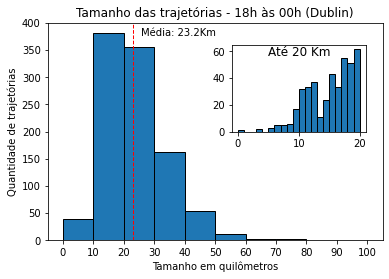

In [36]:
### Plota o gráfico do tamanho das trajetórias de Dublin

tamTrip = [int(i/1000) for i in tamTrips if i < 100000 and i > 150]
tamTrip20Km = [(i/1000) for i in tamTrips if i < 20000 and i > 150]

fig, ax = plt.subplots()
axIns = ax.inset_axes([0.55, 0.5, 0.4, 0.4])

index = np.arange(0,101,10)
index = [int(i) for i in index]

ax.set_xticks(index)

plt.hist(tamTrip, bins=range(0,101,10), edgecolor='black',align='mid')
axIns.hist(tamTrip20Km, bins=range(21), edgecolor='black',align='mid')

#plota linha com média
plt.axvline(np.mean(tamTrip), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(tamTrip)*1.1, max_ylim*0.94, 'Média: {:.1f}Km'.format(np.mean(tamTrip)))

axIns.set_title("Até 20 Km",y=0.8)
plt.title('Tamanho das trajetórias - 18h às 00h (Dublin)')  
plt.xlabel('Tamanho em quilômetros')
plt.ylabel('Quantidade de trajetórias')

plt.savefig(path+"/img/histTamTrajs_Dublin_18To0.png", dpi=300, transparent=False,
            facecolor='white')
plt.show()

In [ ]:
def dublinQtdTripsPorVeic():
    qtdTrips = []
    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.sort_values(['vehicle ID', 'Timestamp'])

    ids = df['vehicle ID'].unique()

    # Pegar os valores únicos de Vehicle Jouney ID para cada veiculo
    for id in ids:
        df_id = df.loc[df['vehicle ID'] == id]
        qtdTrips.append(df_id['vehicle journey ID'].nunique())

    return qtdTrips
qtdTrips = dublinQtdTripsPorVeic()


In [ ]:
### Plota o gráfico da quantidade de trips por veículo
fig, ax = plt.subplots()
index = np.arange(0,56,5)
index = [int(i) for i in index]

ax.set_xticks(index)

plt.hist(qtdTrips, bins=range(0,56,5), edgecolor='black',align='mid')

#plota linha com média
plt.axvline(np.mean(qtdTrips), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(qtdTrips)*1.1, max_ylim*0.94, 'Média: {:.2f}'.format(np.mean(qtdTrips)))

plt.title('Quantidade de trajetórias por veículo em um dia(Dublin)')  
plt.xlabel('Quantidade de trajetórias')
plt.ylabel('Quantidade de veículos')

plt.savefig(path+"/img/histQtdTrips_Dublin.png", dpi=300, transparent=False, facecolor='white')
plt.show()

In [48]:
def stayPoint_Detection():
    """Algoritmo para detecção de paradas"""

    #print('\nColetando pontos de parada...')
    for key in keys:
        separator[key] = []
        numPontos = len(pontos[key])

        i = 0
        while i < numPontos-1:
            dist = distDoisPontos(i, i+1, pontos[key])

            if dist > limitDist:
                tempo = tempoDoisPontos(i, i+1, pontos[key])

                if tempo > limitTempo:
                    separator[key].append(i)
            i += 1

        separator[key].append(numPontos-1)  # Adiciona ponto final
    #print('Pronto!')
limitDist = 25
limitTempo = timedelta(seconds=15)
stayPoint_Detection()

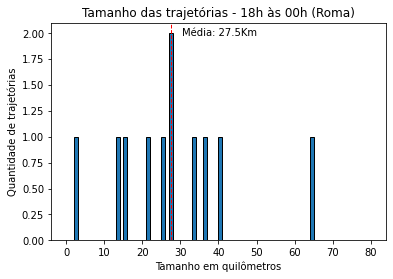

In [58]:
def histTamTraj():

    horario1Inicio = datetime.strptime("2014-02-04 00:00:00",'%Y-%m-%d %H:%M:%S')
    horario1Fim = datetime.strptime("2014-02-04 05:59:59",'%Y-%m-%d %H:%M:%S')
    horario2Inicio = datetime.strptime("2014-02-04 06:00:00",'%Y-%m-%d %H:%M:%S')
    horario2Fim = datetime.strptime("2014-02-04 11:59:59",'%Y-%m-%d %H:%M:%S')
    horario3Inicio = datetime.strptime("2014-02-04 12:00:00",'%Y-%m-%d %H:%M:%S')
    horario3Fim = datetime.strptime("2014-02-04 17:59:59",'%Y-%m-%d %H:%M:%S')
    horario4Inicio = datetime.strptime("2014-02-04 18:00:00",'%Y-%m-%d %H:%M:%S')
    horario4Fim = datetime.strptime("2014-02-04 23:59:59",'%Y-%m-%d %H:%M:%S')

    # horarioInicio = horario1Inicio
    # horariofim = horario1Fim
    # horarioInicio = horario2Inicio
    # horariofim = horario2Fim
    # horarioInicio = horario3Inicio
    # horariofim = horario3Fim
    horarioInicio = horario4Inicio
    horariofim = horario4Fim

              
    tamTrajs = []

    for key in keys:
        begin = 0

        for item in separator[key]:
            dist = 0
            timeInicio = datetime.strptime(pontos[key][0].pointData["Hora"],'%Y-%m-%d %H:%M:%S')
            
            if timeInicio >= horarioInicio and timeInicio <= horariofim:
            # if True:
            
                for i in range(begin,item):
                    dist += distDoisPontos(i,i+1,pontos[key]) 

                tamTrajs.append(dist)
            begin = item+1

    tamTrajs = [int(i/1000) for i in tamTrajs if i <= 300000 and int(i/1000) > 0]
    tamTrajs20Km = [i for i in tamTrajs if i <= 20000 and i > 0]

    # tamTrajs = [i for i in tamTrajs if i <= 40000 and i >= 1]
    # tamTrajs20Km = [i for i in tamTrajs if i <= 1000 and i >= 1]  
    # print(min(tamTrajs), max(tamTrajs))

    fig, ax = plt.subplots()
    # index = np.arange(0,40001,40000/5)
    # index = [int(i) for i in index]
    
    # ax.set_xticks(index)

    # axIns = ax.inset_axes([0.55, 0.55, 0.4, 0.4])

    plt.hist(tamTrajs, bins=range(0,81,1), edgecolor='black',align='mid')
    axIns.hist(tamTrajs20Km, bins=range(21), edgecolor='black',align='mid')

    #plota linha com média
    plt.axvline(np.mean(tamTrajs), color='red', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(np.mean(tamTrajs)*1.1, max_ylim*0.94, 'Média: {:.1f}Km'.format(np.mean(tamTrajs)))

    plt.title('Tamanho das trajetórias - 18h às 00h (Roma)')  
    plt.xlabel('Tamanho em quilômetros')
    plt.ylabel('Quantidade de trajetórias')
    axIns.set_title("Até 20 Km",y=0.8)
    plt.savefig(path+'/img/histTamTrajs_Roma_18To0.png', dpi=300, transparent=False, facecolor='white')
    # plt.savefig(path+'/img/histTamTrajs_b.png', dpi=100, transparent=False, facecolor='white')
    # plt.savefig(path+'/img/histTamTrajs_Dublin.png', dpi=100, transparent=False, facecolor='white')

    plt.show()
    
histTamTraj()

In [ ]:
def histTempoPorTraj():
    tempos = []

    for key in keys:
        ant = 0
        
        for item in separator[key]:
            
            # print('Inicial: ',ant,' | ','Final: ',item)
            tempo = tempoDoisPontos(ant,item,pontos[key])
            tempo = tempo.total_seconds()
            tempos.append(tempo)
            ant = item+1
    tempos = [i/60 for i in tempos if i < 10000 and int(i/60) > 0] # converte de segundos para minutos
    tempos60Min = [i for i in tempos if i < 60]
    
    fig, ax = plt.subplots()
    axIns = ax.inset_axes([0.39, 0.39, 0.6, 0.6])

    plt.hist(tempos, bins=range(0,151,5), edgecolor='black',align='mid',rwidth=1.5)
    axIns.hist(tempos60Min, bins=range(0,21,1), edgecolor='black',align='mid')

    #plota linha com média
    plt.axvline(np.mean(tempos), color='red', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(np.mean(tempos)*1.2, max_ylim*0.2, 'Média: {:.1f}\''.format(np.mean(tempos)))

    plt.title('Tempo das trajetórias(Roma)')
    axIns.set_title("Até 20\'",x=0.5,y=0.8)

    plt.xlabel('Tempo em minutos')
    plt.ylabel('Quantidade de trajetórias')
    # plt.savefig(path+'/img/histTempoTrips_Roma.png', dpi=300, transparent=False, facecolor='white')
    plt.show()

histTempoPorTraj()

In [ ]:
def mapaOnibusReal():

    # Opening the CSV data and dropping columns that are not used
    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.drop(['line ID', 'direction', 'journey pattern ID', 'timeframe', 'operator', 'delay', 'block ID', 'stop ID'], axis = 1)
    
    # Sorting the dataframe and reindexing
    df = df.sort_values(['vehicle ID','Timestamp'])
    df.index = range(len(df))

    df = df.loc[df['vehicle ID'] == 33051]

    df_fluxo = df.loc[df['at stop'] == 0]
    df_parada = df.loc[df['at stop'] == 1]

    lat_fluxo = df_fluxo['lat'].to_numpy()
    longi_fluxo = df_fluxo['long'].to_numpy()
    lat_parada = df_parada['lat'].to_numpy()
    longi_parada = df_parada['long'].to_numpy()

    # Get the coord limits
    BBox = (min(min(longi_fluxo),min(longi_parada)),
            max(max(longi_fluxo),max(longi_parada)),
            min(min(lat_fluxo),min(lat_parada)),
            max(max(lat_fluxo),max(lat_parada)))
    # print(BBox)

    # Print each point on the minimap changing color to red everytime the AtStop atribute = 1
    ruh_m = plt.imread(path+'/img/backmaps/backmap_bus.png') #mapa a ser usado de fundo

    fig, ax = plt.subplots()
    ax.scatter(longi_fluxo, lat_fluxo, zorder=1, alpha=1, c='yellow', s=0.5)
    ax.scatter(longi_parada, lat_parada, zorder=1, alpha=1, c='red', s=0.5,marker=".")
    ax.set_title('Mapa de Calor - Onibus 33051')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(ruh_m,zorder=0, extent=BBox, aspect='equal')

    # plt.savefig(path+"/img/mapaOnibus33051.png", dpi=300, transparent=False, facecolor='white')
    plt.show()

mapaOnibusReal()


In [ ]:
def mapaOnibus():
    # Opening the CSV data and dropping columns that are not used
    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.drop(['line ID', 'direction', 'journey pattern ID', 'timeframe', 'operator', 'delay', 'block ID', 'stop ID'], axis = 1)
    
    # Sorting the dataframe and reindexing
    df = df.sort_values(['vehicle ID','Timestamp'])
    df.index = range(len(df))
    df = df.loc[df['vehicle ID'] == 33051]

    lat = df['lat'].to_numpy()
    longi = df['long'].to_numpy()  

    paradas = separator['33051']

    # Separar um DF para as paradas e outro para a translação
    df_paradas = df.loc[paradas]
    df = df.drop(paradas)

    # Get the coord limits
    BBox = (min(longi), max(longi), min(lat), max(lat))  

    # Print each point on the minimap changing color to red everytime the AtStop atribute = 1
    ruh_m = plt.imread(path+'/img/backmaps/backmap_bus2.png') #mapa a ser usado de fundo

    fig, ax = plt.subplots()
    ax.scatter(df['long'], df['lat'], zorder=1, alpha=1, c='yellow', s=0.5)
    ax.scatter(df_paradas['long'], df_paradas['lat'], zorder=1, alpha=1, c='red', s=0.5,marker=".")
    ax.set_title('Mapa de Calor - Onibus 33051 Gerado')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(ruh_m,zorder=0, extent=BBox, aspect='equal')

    # plt.savefig(path+"/img/mapaOnibus33051_gerado.png", dpi=300, transparent=False, facecolor='white')
    plt.show()

    
mapaOnibus()

In [ ]:
def boxplot():

    global limitDist
    global limitTempo
    tamTrajs_1 = []
    tamTrajs_2 = []
    tamTrajs_3 = []
    tamTrajs_4 = []
    
    limitDist = 25
    limitTempo = timedelta(seconds=15)
    # limitDist = 350
    # limitTempo = timedelta(seconds=30)
    stayPoint_Detection()

    for key in keys:
        begin = 0

        for item in separator[key]:
            dist = 0

            for i in range(begin,item):
                dist += distDoisPontos(i,i+1,pontos[key]) 

            tamTrajs_1.append(dist)
            begin = item+1
    
    limitDist = 25
    limitTempo = timedelta(seconds=18)
    # limitDist = 300
    # limitTempo = timedelta(seconds=38)
    stayPoint_Detection()

    for key in keys:
        begin = 0

        for item in separator[key]:
            dist = 0

            for i in range(begin,item):
                dist += distDoisPontos(i,i+1,pontos[key]) 

            tamTrajs_2.append(dist)
            begin = item+1

    limitDist = 50
    limitTempo = timedelta(seconds=15)
    # limitDist = 300
    # limitTempo = timedelta(seconds=30)
    stayPoint_Detection()

    for key in keys:
        begin = 0

        for item in separator[key]:
            dist = 0

            for i in range(begin,item):
                dist += distDoisPontos(i,i+1,pontos[key]) 

            tamTrajs_3.append(dist)
            begin = item+1

    limitDist = 50
    limitTempo = timedelta(seconds=18)
    # limitDist = 350
    # limitTempo = timedelta(seconds=38)
    stayPoint_Detection()

    for key in keys:
        begin = 0

        for item in separator[key]:
            dist = 0

            for i in range(begin,item):
                dist += distDoisPontos(i,i+1,pontos[key]) 

            tamTrajs_4.append(dist)
            begin = item+1

    data = [tamTrajs_1, tamTrajs_2, tamTrajs_3, tamTrajs_4]
    
    fig, ax = plt.subplots()

    # Creating plot
    ax.boxplot(data,showfliers=False)
    ax.set_title("Tamanho das trajetórias(Roma)")
    ax.set_ylabel("Tamanho em metros")
    ax.set_xlabel("Limites Estabelecidos")
    ax.set_xticklabels(["Distância: 25m\nTempo: 15s","Distância: 25m\nTempo: 18s","Distância: 50m\nTempo: 15s","Distância: 50m\nTempo: 18s"],fontdict={"fontsize":7})
    # ax.set_xticklabels(["Distância: 350m\nTempo: 30s","Distância: 300m\nTempo: 38s","Distância: 300m\nTempo: 30s","Distância: 350m\nTempo: 38s"],fontdict={"fontsize":7})

    plt.savefig(path+'/img/boxplotTamTrajs_Roma.png', dpi=150, transparent=False, facecolor='white')
    plt.show()

boxplot()

In [ ]:
def histVelPorTraj():
    listVel = []

    for key in keys:
        begin = 0
        for item in separator[key]:
            dist = int(distDoisPontos(begin,item,pontos[key]))
            tempo = tempoDoisPontos(begin,item,pontos[key])
            tempo = tempo.total_seconds()
            if(tempo != 0 and dist != 0):
                vel = int(dist/tempo)
                listVel.append(vel)
            begin = item+1

    listVel = [i for i in listVel if i < 150 and i > 0] # exclusao dos outliers
    listVelKmH = [i*3.6 for i in listVel]

    fig, ax = plt.subplots()
    axIns = ax.inset_axes([0.39, 0.39, 0.6, 0.6])

    index = np.arange(0,56,5)
    index = [int(i) for i in index]

    ax.set_xticks(index)

    plt.hist(listVel, bins=range(0,76,5), edgecolor='black',align='mid',rwidth=1.5)
    axIns.hist(listVelKmH, bins=range(0,251,25), edgecolor='black',align='mid')

    #plota linha com média
    plt.axvline(np.mean(listVel), color='red', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(np.mean(listVel)*1.6, max_ylim*0.2, 'Média: {:.1f}m/s'.format(np.mean(listVel)))

    axIns.set_title("Em Km/H",x=0.7,y=0.8)
    plt.title('Velocidade Média das Trajetórias(Roma)')  
    plt.xlabel('Velocidade em Metros/Segundo')
    plt.ylabel('Quantidade de trajetórias')
    # plt.savefig(path+'/img/histVelTrips_Roma.png', dpi=300, transparent=False, facecolor='white')

    plt.show()

histVelPorTraj()

In [ ]:
def cdfTempo():
    """Função que plota uma cdf com os dados de distancia entre pontos de todos veículos"""

    # x = [i for i in timeGapsDiscrete if i <= 100]
    x = [i for i in timeGapsDiscrete if i <= 100]

    #  Definição dos valores da lista
    sigma = np.std(x)
    mu = sum(x)/len(x)
    n_bins = 100

    _, ax = plt.subplots(figsize=(8, 4))

    #  Histograma cumulativo
    _, bins, _ = ax.hist(x, n_bins, density=True, histtype='step',
                         cumulative=True, label='Empírica')
    
    '''
    #  Distribuição esperada
    y = ((1 / (np.sqrt(2 * np.pi) * sigma))
         * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

    y = y.cumsum()
    y /= y[-1]

    ax.plot(bins, y, 'r--', linewidth=1.5, label='Teórica')
    '''

    #  Histograma cumulativo inverso
    # ax.hist(x, bins=bins, density=True, histtype='step',
    #       cumulative=-1,label='Emp. Inversa')

    # plota linha vertical
    plt.axvline(30,ymax=0.92, color='red', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(30*0.95, max_ylim*-0.05, '{:d}'.format(30))

    #plota linha horizontal
    plt.axhline(0.965, color='red', linestyle='dashed', linewidth=1)
    min_xlim, max_xlim = plt.xlim()
    plt.text(max_xlim*1.01, 0.97*0.98, '{:.2f}'.format(0.95))

    #  Detalhes do gráfico
    ax.grid(True)
    # ax.legend(loc='right')
    ax.set_title('Função de Densidade Cumulativa - Tempo entre pontos(Dublin)')
    ax.set_xlabel('Tempo em segundos')
    ax.set_ylabel('Probabilidade cumulativa de ocorrência')

    # plt.savefig(path+'/img/cdfTempo_Dublin.png',dpi=100, transparent=False, facecolor='white')
    plt.show()
cdfTempo()

In [ ]:
def cdfDistancia():
    """Função que plota uma cdf com os dados de distancia entre pontos de todos veículos"""

    # x = [i for i in coordGapsDiscrete if i <= 100]
    x = [i for i in coordGapsDiscrete if i <= 500]

    #  Definição dos valores da lista
    sigma = np.std(x)
    mu = sum(x)/len(x)
    n_bins = 100

    _, ax = plt.subplots(figsize=(8, 4))

    #  Histograma cumulativo
    _, bins, _ = ax.hist(x, n_bins,
                         density=True, histtype='step',
                         cumulative=True, label='Empírica')
    '''
    #  Distribuição esperada
    y = ((1 / (np.sqrt(2 * np.pi) * sigma))
         * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

    y = y.cumsum()
    y /= y[-1]

    ax.plot(bins, y, 'r--', linewidth=1.5, label='Teórica')
    '''

    #  Histograma cumulativo inverso
    # ax.hist(x, bins=bins, density=True, histtype='step',
    #       cumulative=-1,label='Emp. Inversa')

    # plota linha vertical
    plt.axvline(350,ymax=0.88, color='red', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(350*0.96, max_ylim*-0.05, '{:d}'.format(350))

    #plota linha horizontal
    plt.axhline(0.92, color='red', linestyle='dashed', linewidth=1)
    min_xlim, max_xlim = plt.xlim()
    plt.text(max_xlim*1.01, 0.92*0.98, '{:.2f}'.format(0.92))

    #  Detalhes do gráfico
    ax.grid(True)
    # ax.legend(loc='right')
    ax.set_title('Função de Densidade Cumulativa - Distância entre pontos(Dublin)')
    ax.set_xlabel('Distância em metros')
    ax.set_ylabel('Probabilidade cumulativa de ocorrência')

    # plt.savefig(path+'/img/cdfDistancia_Dublin.png',dpi=100, transparent=False, facecolor='white')
    plt.show()
cdfDistancia()

In [ ]:
def trajPorVeic():
    """Função para calcular e plotar um histograma da quantidade 
        de trajetórias por veículo.
    """
    from scipy.stats import poisson
    from scipy.optimize import curve_fit

    def fit_function(k, lamb):
        '''poisson function, parameter lamb is the fit parameter'''
        return poisson.pmf(k, lamb)

    trajCounter = []
    for key in separator:
        trajCounter.append(len(separator[key]))

    print(max(trajCounter))
        
    fig, ax = plt.subplots()
    # index = np.arange(0,81,5)
    # index = [int(i) for i in index]
    # index.append(max(trajCounter))
    
    # ax.set_xticks(index)

    entries, bin_edges, patches = plt.hist(trajCounter, bins=range(0,81,5), edgecolor='black',density=True,align='mid')
    bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    # print(bin_middles)
    # print(entries)

    popt, pcov = curve_fit(fit_function, bin_middles, entries,[26])
    print(popt,pcov)

    x_plot = np.arange(0,51)
    y_plot = fit_function(x_plot,*popt)

    plt.plot(x_plot,y_plot, '-', color='red')

    #plota linha com média
    plt.axvline(np.mean(trajCounter), color='red', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(np.mean(trajCounter)*1.2, max_ylim*0.8, 'Média: {:.1f}'.format(np.mean(trajCounter)))

    plt.title('Quantidade de viagens por veículo(Roma)')  
    plt.xlabel('Quantidade de viagens')
    plt.ylabel('Quantidade de veículos')
    # plt.savefig(path+'/img/qtdViagens_Roma.png', dpi=300, transparent=False, facecolor='white')
    # plt.savefig(path+'/img/histTrajPorVeic_Dublin.png', dpi=100, transparent=False, facecolor='white')

    plt.show()

trajPorVeic()

In [ ]:
def cdfTrajPorVeic():
    """Função que plota uma cdf com os dados de quantidades de trajetórias de todos veículos"""
    
    trajCounter = []
    for key in separator:
        trajCounter.append(len(separator[key]))

    #x = [i for i in coordGapsDiscrete if i <= 100]
    x = [i for i in trajCounter]
    
    #  Definição dos valores da lista
    sigma = np.std(x)
    mu = sum(x)/len(x)
    n_bins = 12

    _, ax = plt.subplots(figsize=(8, 4))

    #  Histograma cumulativo
    _, bins, _ = ax.hist(x, n_bins,
                         density=True, histtype='step',
                         cumulative=True, label='Empírica')

    '''
    #  Distribuição esperada
    y = ((1 / (np.sqrt(2 * np.pi) * sigma))
         * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

    y = y.cumsum()
    y /= y[-1]

    ax.plot(bins, y, 'r--', linewidth=1.5, label='Teórica')
    '''

    #  Histograma cumulativo inverso
    # ax.hist(x, bins=bins, density=True, histtype='step',
    #       cumulative=-1,label='Emp. Inversa')

    #  Detalhes do gráfico
    ax.grid(True)
    # ax.legend(loc='right')
    ax.set_title('Função de Densidade Cumulativa - Quantidade de trajetórias por veículo(Dublin)')
    ax.set_xlabel('Quantidade de trajetórias')
    ax.set_ylabel('Probabilidade cumulativa de ocorrência')

    #plt.savefig(path+'/img/cdfTrajPorVeic_Roma.png', transparent=False, facecolor='white')
    # plt.savefig(path+'/img/cdfTrajPorVeic_Dublin.png', transparent=False, facecolor='white')

    plt.show()

cdfTrajPorVeic()

In [ ]:
def trajPorHora():
    """Função para calcular e plotar um histograma da quantidade 
        de trajetórias por veículo.
    """
    
    trajCounter = [0 for i in range(0,25)]
    listHora = [i for i in range(0,25)]
    
    for i in range(0,24):    
        for key in separator:
            for item in separator[key]:
                pointTime = pontos[key][item].pointData['Hora']
                pointTime = datetime.strptime(pointTime, '%Y-%d-%m %H:%M:%S')
        
                if i+1 == 24:
                    limSup = datetime(2014,4,3,0,0,0)
                else:
                    limSup = datetime(2014,4,2,i+1,0,0)
                limInf = datetime(2014,4,2,i,0,0)
                
                
                if pointTime >= limInf and pointTime < limSup:
                    trajCounter[i] = trajCounter[i] + 1
        
        
    fig, ax = plt.subplots()

    index = np.arange(len(trajCounter))
    bar_width = 1
    score_label = np.arange(0,1001,200)
    bar = ax.bar(index, trajCounter, bar_width, label='Quantidade de Trajetórias',align='edge',edgecolor='#000000')

    #setting labels
    ax.set_ylabel('Quantidade de Trajetórias')
    ax.set_xlabel('Hora do dia')

    #setting axis
    ax.set_xticks(index)
    ax.set_xticklabels(listHora,fontsize=7)
    ax.set_yticks(score_label)
    ax.set_yticklabels(score_label)
    
    plt.title('Quantidade de Trajetórias x Hora do dia')

    #plt.savefig(path+'/img/trajPorHora.png', dpi=100, transparent=False, facecolor='white')
    #plt.savefig(path+'/img/trajPorHora_b.png', dpi=100, transparent=False, facecolor='white')
    # plt.savefig(path+'/img/trajPorHora_Dublin.png', dpi=100, transparent=False, facecolor='white')
    plt.show()

trajPorHora()

In [ ]:
def densTrajPorHora():
    trajCounter = [0 for i in range(0,24)]
    listHora = [i for i in range(0,24)]
    densTrajCounter = []
    
    for i in range(0,24):    
        for key in separator:
            for item in separator[key]:
                pointTime = pontos[key][item].pointData['Hora']
                pointTime = datetime.strptime(pointTime, '%Y-%d-%m %H:%M:%S')
        
                if i+1 == 24:
                    limSup = datetime(2014,4,3,0,0,0)
                else:
                    limSup = datetime(2014,4,2,i+1,0,0)
                limInf = datetime(2014,4,2,i,0,0)
                
                
                if pointTime >= limInf and pointTime < limSup:
                    trajCounter[i] = trajCounter[i] + 1

    for i in range(0,24):
        x = trajCounter[i]
        newlist = [i] * x
        densTrajCounter.extend(newlist)
        
    index = np.arange(len(listHora))

    fig, ax = plt.subplots()
    
    #setting labels
    ax.set_ylabel('Densidade de Trajetórias')
    ax.set_xlabel('Hora do dia')

    ax.set_xticks(index)
    ax.set_xticklabels(listHora,fontsize=8)
    
    sns.histplot(densTrajCounter, stat="density", binwidth = 1)
    sns.kdeplot(densTrajCounter, color='red')
    
    #plt.savefig(path+'/img/dens_trajPorHora.png', dpi=100, transparent=False, facecolor='white')
    #plt.savefig(path+'/img/dens_trajPorHora_b.png', dpi=100, transparent=False, facecolor='white')
    # plt.savefig(path+'/img/dens_trajPorHora_Dublin.png', dpi=100, transparent=False, facecolor='white')
    plt.title('Densidade de Trajetórias x Hora do dia')
    plt.show()
    
densTrajPorHora()

In [ ]:
def cdfTempoPorTraj():
    tempos = []
    
    for key in keys:
        ant = 0
        
        for item in separator[key]:
            
            # print('Inicial: ',ant,' | ','Final: ',item)
            tempo = tempoDoisPontos(ant,item,pontos[key])
            tempo = tempo.total_seconds()
            tempos.append(tempo)
            ant = item+1
    tempos = [i/60 for i in tempos if i < 10000] # converte de segundos para minutos
    
    x = tempos

    #  Definição dos valores da lista
    sigma = np.std(x)
    mu = sum(x)/len(x)
    n_bins = 100

    _, ax = plt.subplots(figsize=(8, 4))

    #  Histograma cumulativo
    _, bins, _ = ax.hist(x, n_bins, density=True, histtype='step',
                         cumulative=True, label='Empírica')

    '''
    #  Distribuição esperada
    y = ((1 / (np.sqrt(2 * np.pi) * sigma))
         * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

    y = y.cumsum()
    y /= y[-1]

    ax.plot(bins, y, 'r--', linewidth=1.5, label='Teórica')
    '''

    #  Histograma cumulativo inverso
    # ax.hist(x, bins=bins, density=True, histtype='step',
    #       cumulative=-1,label='Emp. Inversa')

    #  Detalhes do gráfico
    ax.grid(True)
    # ax.legend(loc='right')
    ax.set_title('Função de Densidade Cumulativa - Tempo por Trajetória(Dublin)')
    ax.set_xlabel('Tempo em minutos')
    ax.set_ylabel('Probabilidade cumulativa de ocorrência')

    #plt.savefig(path+'/img/cdfTempPorTraj_Roma.png', transparent=False, facecolor='white')
    plt.savefig(path+'/img/cdfTempPorTraj_Dublin.png', transparent=False, facecolor='white')
    plt.show()
    
    
cdfTempoPorTraj()

In [ ]:
def mapaCalorOrigem():
    origens = []
    
    # separar lista de pontos de origem
    for key in keys:
        ant = 0
        
        for item in separator[key]:
            
            ponto = pontos[key][ant].pointData['Coord']
            origens.append(ponto)
            ant = item+1
            
    # plotar lista no mapa
    
    longOrig = [i[1] for i in origens]
    latOrig = [i[0] for i in origens]

    BBox = (min(longOrig),max(longOrig),min(latOrig),max(latOrig)) #limites laterais do mapa
    # print(BBox)
    
    ruh_m = plt.imread(path+'/img/backmaps/backmap_orig.png') #mapa a ser usado de fundo

    fig, ax = plt.subplots()
    ax.scatter(longOrig, latOrig, zorder=1, alpha=1, c='#d1432a', s=0.5,marker=".")
    ax.set_title('Mapa de Calor - Origem')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(ruh_m,zorder=0, extent=BBox, aspect='equal')
    
    #plt.savefig(path+"/img/mapaCalorOrigem.png", dpi=300, transparent=False, facecolor='white')
    #plt.savefig(path+"/img/mapaCalorOrigem_b.png", dpi=300, transparent=False, facecolor='white')
    plt.show()
    
mapaCalorOrigem()

In [ ]:
def mapaCalorDestino():
    destinos = []
    
    # separar lista de pontos de destino
    for key in keys:
        for item in separator[key]:
            ponto = pontos[key][item].pointData['Coord']
            destinos.append(ponto)
            
    # plotar lista no mapa
    
    longDest = [i[1] for i in destinos]
    latDest = [i[0] for i in destinos]

    BBox = (min(longDest),max(longDest),min(latDest),max(latDest)) #limites laterais do mapa
    # print(BBox)
    
    
    ruh_m = plt.imread(path+'/img/backmaps/backmap_bus.png') #mapa a ser usado de fundo

    fig, ax = plt.subplots()
    ax.scatter(longDest, latDest, zorder=1, alpha=1, c='#d1432a', s=0.5,marker=".")
    ax.set_title('Mapa de Calor - Destino')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(ruh_m,zorder=0, extent=BBox, aspect='equal')
    
    #plt.savefig(path+"/img/mapaCalorDestino.png", dpi=300, transparent=False, facecolor='white')
    #plt.savefig(path+"/img/mapaCalorDestino_b.png", dpi=300, transparent=False, facecolor='white')
    plt.show()
mapaCalorDestino()